# Chapter 2 - Multi-armed Bandits

---
### Exercise 2.1 ###
**Q:** 
> In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon=0.5$, what is the probability that the greedy action is selected?

**A:** The probability of selecting the greedy action is $1-\epsilon = 1-0.5 = 0.5$. 

---
### Exercise 2.2
**Q:** 
> Consider a k-armed bandit problem with $k=4$ actions, denoted 1,2,3, and 4. Consider applying to this problem a bandit algorithm using $\epsilon$-greedy, sample-average action-value estimates, and initial estimates of $A_1(a)=0$, $\forall a$. Suppose the initial sequence of actions and rewards is $A_1=1, R_1=-1,A_2=2,R_2=1,A_3=2,R_3=-2,A_4=2,R_4=2,A_5=3,R_5=0$. 
On some of these time steps the $\epsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

**A:** The action-value estimate $Q_t(a)$ for each action $a$ after each time step $t$ is shown in the following table:

| $t$ | $A_1$ | $A_2$ | $A_3$ | $A_4$ |
|-----|-------|-------|-------|-------|
|  1  |   -1  |   0   |   0   |   0   |
|  2  |   -1  |   1   |   0   |   0   |
|  3  |   -1  |  -0.5 |   0   |   0   |
|  4  |   -1  | 0.333 |   0   |   0   |
|  5  |   -1  | 0.333 |   0   |   0   |

At time step $5$, $A_3$ is selected, despite $A_2$ having the highest action-value estimate of $0.333$, and so the $\epsilon$ case must have occurred here (the greedy choice would be to choose $A_2$). The $\epsilon$ case could also have occurred on time steps $1$ and $2$, however in these cases there were multiple actions with the maximum action-value estimate, and so the agent would have chosen one of these randomly even if the $\epsilon$ case did not occur.

---
### Exercise 2.3

**Q:**
> In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

**A:** In this example, the optimum reward-per-step is 'about $1.55$', and the reward $R_t$ of selecting action $A_t$ is sampled from a normal distribution with mean $q_*(A_t)$ and variance 1.

In the long run (once all methods have converged on the optimal action), the greedy method converges to an average reward-per-step of 1. The $\epsilon=0.1$ method selects the optimal action with probability $0.9$ of the time, giving an average reward-per-step of $0.9 \times 1.55 = 1.395$. The $\epsilon=0.01$ selects the optimal action with a probability of $0.99$, giving an average reward-per-step of $0.99 \times 1.55 = 1.5345$.

In terms of cumulative reward after convergence, the $\epsilon=0.01$ method will perform best. However in the example shown, up to the maximum 1000 steps, the $\epsilon=0.1$ method performs best, and it is clear from visual inspection that this method has the greatest area under the curve (cumulative reward).

In general, cumulative reward depends on how many steps the agents are given in the environment. Agents that are slower to learn (smaller $\epsilon$ values), may perform better over very large numbers of steps. 

I am not certain, but I think that theoretically the best possible performance is achieved as the number of steps $N \to \infty$ and $\epsilon \to 0$.

After an arbitrarily high number of time steps, $\epsilon=0.1$ selects the optimal action $90\%$ of the time, $\epsilon=0.01$ selects the optimal action $99\%$ of the time.


---
### Exercise 2.4
**Q:**
> If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters.

**A:** The key difference from (2.6) is starting with $\alpha_n$ instead of $\alpha$:

$Q_{n+1}=Q_n + \alpha_n [ R_n - Q_n ]$

First, gather $Q_n$ and $R_n$ terms:

$\Rightarrow Q_{n+1}=\alpha_n R_n + (1-\alpha_n) Q_n$

Rewrite $Q_n$ in terms of prior time step $n-1$:

$\Rightarrow Q_{n+1}=\alpha_n R_n + (1-\alpha_n)[\alpha_{n-1}R_{n-1} + (1-\alpha_{n-1})Q_{n-1}]$

From here, you can spot the recursive pattern of expansion and express using products of sequences:

$\displaystyle \Rightarrow Q_{n+1}= \alpha_n R_n + \sum_{i=1}^{n-1}{\left[ \alpha_i R_i \prod_{j=i+1}^n{(1-\alpha_j)} \right]} + Q_1 \prod_{i=1}^n{(1-\alpha_i)}$

---
### Exercise 2.5 (Programming)
**Q:**
> Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed bandit testbed in which all the $q_*(a)$ start out equal and the take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha=0.1$. Use $\epsilon=0.1$ and longer runs, say of $10,000$ steps.

In [89]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

class KArmedBandit:
    
    def __init__(self,num_arms=10,epsilon=0.1,step_size=0.1,initial_reward=0,constant_step_size=False):
        self.num_arms = num_arms
        self.epsilon=epsilon
        self.step_size = step_size
        self.actions = np.arange(num_arms)
        self.true_reward = np.full(shape=num_arms,fill_value=initial_reward)
        self.times_chosen = np.zeros(shape=num_arms)
        self.estimated_reward = np.zeros(shape=num_arms)
        self.constant_step_size=constant_step_size
        self.optimal_actions = np.arange(num_arms) #All rewards are initially zero
        self.avg_reward = 0
        self.current_step = 0
        #self.true_reward = np.random.normal(0,5,self.num_arms)
        
    def step(self, mu, sigma): #Advance environment time, updating actual rewards
        # Update all reward values
        self.current_step += 1
        self.true_reward = np.add(self.true_reward,np.random.normal(mu,sigma,self.num_arms))
        self.optimal_actions = np.where(self.true_reward == self.true_reward.max())[0]
                 
    def get_next_action(self): #Return action to take using epsilon-greedy
        if np.random.rand() < self.epsilon: #Epsilon case
            choice = np.random.choice(self.actions)
        else: #Greedy case
            max_value_actions = np.where(self.estimated_reward==self.estimated_reward.max())[0]
            choice = np.random.choice(max_value_actions)            
        return choice
    
    def do_action(self,action): #Carry out action
        reward = self.true_reward[action]
        optimal_choice = 0
        self.times_chosen[action] += 1
        if action in self.optimal_actions:
            optimal_choice = 1
        self.step(0,0.01)
        return reward, optimal_choice
    
    def update_estimates(self,action,R_n): #Revise Q estimates according to update rule
        Q_n = self.estimated_reward[action]
        self.avg_reward += (R_n - self.avg_reward)/self.current_step
        if self.constant_step_size: #Constant step size factor
            self.estimated_reward[action] += self.step_size * (R_n - Q_n)
        else: #Sample average
            self.estimated_reward[action] += (R_n - Q_n)/self.times_chosen[action]
        
    def run_episode(self, episode_length):
        rewards = np.empty(episode_length)
        optimal_choices = np.empty(episode_length)
        for i in range(0, episode_length):
            action = self.get_next_action()
            reward, optimal_choice = self.do_action(action)
            self.update_estimates(action,reward)
            #rewards[i] = self.avg_reward
            rewards[i] = reward
            optimal_choices[i] = optimal_choice
            
        return rewards,optimal_choices
            

def run_testbed(episode_length, num_episodes, constant_step_size):
    rewards = np.zeros(shape=(num_episodes,episode_length))
    optimal_choices = np.zeros(shape=(num_episodes,episode_length))
    print(rewards.shape)
    for i in range(0,num_episodes-1):
        bandit = KArmedBandit(num_arms=10,epsilon=0.1,step_size=0.1,initial_reward=0,constant_step_size=constant_step_size)
        rewards[i],optimal_choices[i] = bandit.run_episode(episode_length=10000)
        
    avg_rewards = np.average(rewards,axis=0)
    avg_optimal_choices = np.average(optimal_choices,axis=0) * 100.
    return avg_rewards, avg_optimal_choices

r1,o1 = run_testbed(10000,2000,True)
r2,o2 = run_testbed(10000,2000,False)

(2000, 10000)
(2000, 10000)


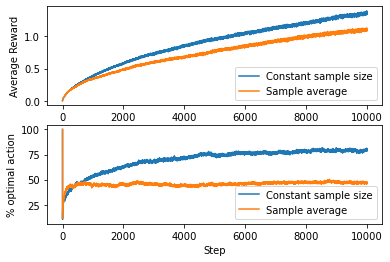

In [90]:
plt.subplot(2,1,1)
plt.plot(r1,label='Constant sample size')
plt.plot(r2,label='Sample average')
plt.legend()
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.subplot(2,1,2)
plt.plot(o1,label='Constant sample size')
plt.plot(o2,label='Sample average')
plt.legend()
plt.xlabel('Step')
plt.ylabel('% optimal action')
plt.show()

---
### Exercise 2.6
**Q:**
> The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

**A:** During early steps, before adequate reward sampling has "washed away" (see below example) the optimistic initial values, the learner selects all the actions multiple times, largely unaffected by the actual rewards it receives from these actions. For this reason, the reward per step will vary significantly, as different actions are being selected in each step.

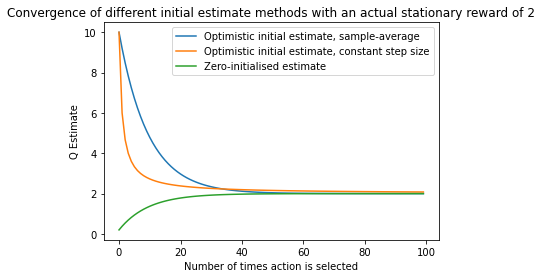

In [81]:
R = 2

# Optimistic initial value w/ sample average
Q_oiv = np.zeros(100)
Q_oiv[0] = 10 
for i in range(1,100):
    Q_oiv[i] = Q_oiv[i-1] + 0.1 * (R - Q_oiv[i-1])

# Optimistic initial value w/ constant step size
Q_css = np.zeros(100)
Q_css[0] = 10 # Optimistic initial value
for i in range(1,100):
    Q_css[i] = Q_css[i-1] + (R - Q_css[i-1])/(i+1)
    
# Zero initial value
Q_ziv = np.zeros(100) # Zero initial value
for i in range(0,100):
    Q_ziv[i] = Q_ziv[i-1] + 0.1 * (R - Q_ziv[i-1])

plt.plot(Q_oiv,label='Optimistic initial estimate, sample-average')
plt.plot(Q_css,label='Optimistic initial estimate, constant step size')
plt.plot(Q_ziv,label='Zero-initialised estimate')
plt.xlabel('Number of times action is selected')
plt.ylabel('Q Estimate')
plt.title('Convergence of different initial estimate methods with an actual stationary reward of 2')
plt.legend()
plt.show()

---
### Exercise 2.7
**Q:**
> In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution bevause they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while reataining their advantages on nonstationary problems? One way is to use a step size of $\beta_n \doteq \alpha / \bar{o}_n$, to process the $n$th reward for a particular action, where $\alpha > 0$ is a conventional constant step size, and $\bar{o}_n$ is a trace of one that starts at 0:
$\bar{o}_n \doteq \bar{o}_{n-1}+\alpha(1-\bar{o}_{n-1})$, for $n\geq 0$, with $\bar{o}_0 \doteq 0$.
Carry out an analysis like that in (2.6) to show that $Q_n$ is an exponential recency-weighted average _without initial bias._

**A:** Starting with the previous equation for action-value estimate with varying step size, substituting $\beta_n$ for $\alpha_n$:

$\displaystyle Q_{n+1}= \beta_n R_n + \sum_{i=1}^{n-1}{\left[ \beta_i R_i \prod_{j=i+1}^n{(1-\beta_j)} \right]} + Q_1 \prod_{i=1}^n{(1-\beta_i)}$

Then we have to show that there is no initial bias. In other words, $Q_1 \prod_{i=1}^n{(1-\beta_i)}=0$. Since $Q_1$ can be non-zero, $\prod_{i=1}^n{(1-\beta_i)}=0$.

First, pull out the $i=1$ term to get $(1-\beta_1)\prod_{i=2}^n{(1-\beta_i)}$.

We know that $1-\beta_1 = 1-\frac{\alpha}{\bar{o}_1}$, and $\bar{o}_1=\bar{o}_0+\alpha (1-\bar{o}_0)$. Using the definition $\bar{o}_0 \doteq 0$, we get $\bar{o}_1 = \alpha$. Thus

$\displaystyle 1-\beta_1 = 1 - \frac{\alpha}{\alpha} = 0$

$\displaystyle \Rightarrow \prod_{i=1}^n{(1-\beta_i)}=0\times\prod_{i=2}^n{(1-\beta_i)}=0$.

The result of this is that there is no $Q_1$ term (initial bias), in action-value estimations.

---
### Exercise 2.8
**Q:**
> In figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for you answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If $c=1$, then the spike is less prominent.

**A:** UCB action selection is computed with 

$\displaystyle A_t \doteq \mathop{\mathrm{arg\,max}}_a \left[ Q_t(a) + c \sqrt{\frac{\ln{t}}{N_t(a)}} \right]$.

The UCB method selects all 10 actions in the first 10 steps, i.e. it is entirely exploratory before all actions have been tried at least once. This is because for any action that has not yet been chosen (i.e. for which $N_t(a)=0$), the uncertainty term $c \sqrt{\frac{\ln{t}}{N_t(a)}}$ explodes, causing the action value estimate to be very high. On the 11th step, all actions have been chosen once, and the method is more likely to choose actions greedily. The likelihood of taking the greedy choice is modulated by the choice of $c$. A larger $c$ makes it less likely that the greedy action will be taken on the 11th step, resulting in a smaller spike in average reward. After the 11th step, the uncertainty term is likely to dominate again, since other actions have been chosen half as much as the previously selected one, hence the subsequent dip in average reward.

---
### Exercise 2.9
**Q:**
> Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.

**A:** For two actions, the softmax distribution is given by

$\displaystyle \mathrm{Pr}\{A_t=a\}\doteq\frac{e^{H_t(a)}}{e^{H_t(a)}+e^{H_t(a')}} \doteq \pi_t(a) $, where $a'$ denotes the action that is not $a$.

The logistic function:

$\displaystyle f(x) = \frac{L}{1+e^{-k(x-x_o)}}$.

Setting $x=H_t(a)$ and $x_o=\frac{H_t(a)+H_t(a')}{2}$ gives:

$\displaystyle f(H_t(a)) = \frac{L}{1+e^{-\frac{k}{2}(H_t(a)-H_t(a'))}}$

$\displaystyle \Rightarrow f(H_t(a)) = \frac{L}{1+e^{-\frac{k}{2}H_t(a)}e^{\frac{k}{2}H_t(a')}}$.

We can choose $k=2$, and $L=1$ to get

$\displaystyle f(H_t(a)) = \frac{1}{1+e^{-H_t(a)}e^{H_t(a')}}$

$\displaystyle \Rightarrow f(H_t(a)) = \frac{1}{1+e^{-H_t(a)}e^{H_t(a')}}\times\frac{e^{H_t(a)}}{e^{H_t(a)}}$

$\displaystyle \Rightarrow f(H_t(a)) = \frac{e^{H_t(a)}}{e^{H_t(a)}+e^{H_t(a')}} = \pi_t(a)$.

---
### Exercise 2.10

**Q:**
> Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions $1$ and $2$ are respectively $10$ and $20$ with probability $0.5$ (case A), and $90$ and $80$ with probability $0.5$ (case B). If you are not able to tell which case you face at any step, what is the best expected reward you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don't know the true action values). This is an associative search task. What is the best expected reward you can achieve in this task, and should you behave to achieve it?